In [2]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout

In [3]:
# Paths to your training and validation CSV files and image folders
train_csv = '/kaggle/input/gi-track/Training.csv'
train_image_folder = '/kaggle/input/gi-track/All_Images/Training'

val_csv = '/kaggle/input/gi-track/Validation.csv'
val_image_folder = '/kaggle/input/gi-track/All_Images/Validation'

test_csv = '/kaggle/input/gi-track/Testing.csv'
test_image_folder = '/kaggle/input/gi-track/All_Images/Testing'

# Load training and validation data from CSV files
train_data = pd.read_csv(train_csv)
train_data['class'] = train_data['class'].astype(str)

val_data = pd.read_csv(val_csv)
val_data['class'] = val_data['class'].astype(str)

# Load test data CSV
test_data = pd.read_csv(test_csv)
test_data['class'] = test_data['class'].astype(str)

# Create an ImageDataGenerator for training data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'  # Ensure class_mode is 'binary' and 'y_col' values are strings
)

# Flow from dataframe for validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=val_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

# Flow from dataframe for test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=test_image_folder,
    x_col='filename',
    y_col='class',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',  # Ensure class_mode is 'binary' and 'y_col' values are strings
    shuffle=False
)

Found 2412 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.
Found 521 validated image filenames belonging to 2 classes.


In [4]:
# Build the model (Using a pre-trained model for transfer learning)
weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(256, 256, 3), weights=weights_path)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.7)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    callbacks=[early_stop]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/40


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/76 ━━━━━━━━━━━━━━━━━━━━ 58:07 47s/step - accuracy: 0.5625 - loss: 0.7548

I0000 00:00:1719977839.988298     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719977840.011716     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.5294 - loss: 0.7330

W0000 00:00:1719977882.269671     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719977913.105785     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


76/76 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.5296 - loss: 0.7328 - val_accuracy: 0.5820 - val_loss: 0.6663
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - accuracy: 0.5247 - loss: 0.7043 - val_accuracy: 0.6189 - val_loss: 0.6444
Epoch 3/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 173ms/step - accuracy: 0.6101 - loss: 0.6521 - val_accuracy: 0.6148 - val_loss: 0.6273
Epoch 4/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.6332 - loss: 0.6306 - val_accuracy: 0.6148 - val_loss: 0.6137
Epoch 5/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.6602 - loss: 0.6210 - val_accuracy: 0.6107 - val_loss: 0.6056
Epoch 6/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 0.6597 - loss: 0.6059 - val_accuracy: 0.6311 - val_loss: 0.5988
Epoch 7/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 171ms/step - accuracy: 0.6592 - loss: 0.5965 - val_accuracy: 0.6066 - val_loss: 0.5883
Epoch 8/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - accuracy: 0.6809 - loss: 0.5793 - val_accuracy: 0.6189 

In [5]:
# Save the model
model.save('/kaggle/working/VGG16_model_Mix.h5')

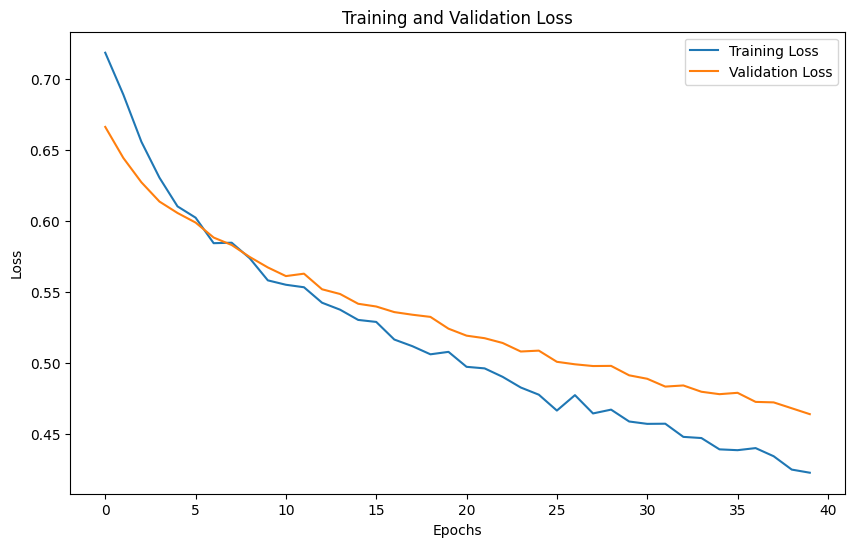

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Evaluate the model
val_generator.reset()
predictions = model.predict(val_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = val_generator.classes

2/8 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step

W0000 00:00:1719978490.544199     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step


W0000 00:00:1719978492.055849     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[ 75  34]
 [ 13 122]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.85      0.69      0.76       109
    bleeding       0.78      0.90      0.84       135

    accuracy                           0.81       244
   macro avg       0.82      0.80      0.80       244
weighted avg       0.81      0.81      0.80       244


Class 0 - Non-Bleeding:
Sensitivity: 0.6881
Specificity: 0.9037
True Positive Rate: 0.6881
False Positive Rate: 0.0963

Class 1 - Bleeding:
Sensitivity: 0.9037
Specificity: 0.6881
True Positive Rate: 0.9037
False Positive Rate: 0.3119

ROC Curve Values:
FPR: [0.         0.00917431 0.00917431 0.01834862 0.01834862 0.02752294
 0.02752294 0.04587156 0.04587156 0.05504587 0.05504587 0.06422018
 0.06422018 0.0733945  0.0733945  0.08256881 0.08256881 0.09174312
 0.09174312 0.11009174 0.11009174 0.11926606 0.11926606 0.12844037
 0.12844037 0.13761468 0.13761468 0.14678899 0.14678899 0.1559633
 0.1559633  0.165

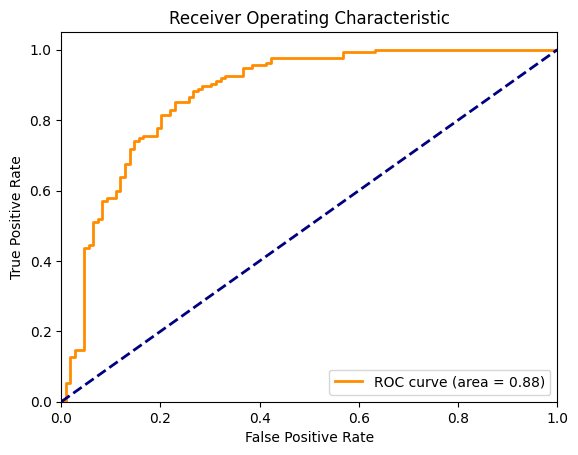

In [8]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [9]:
# Load the previously saved model
model = tf.keras.models.load_model('/kaggle/working/VGG16_model_Mix.h5')

# Evaluate the model on test data
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/17 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step 

W0000 00:00:1719978498.317392     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step 


W0000 00:00:1719978518.882120     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[250  70]
 [ 23 178]]
Classification Report
              precision    recall  f1-score   support

non-bleeding       0.92      0.78      0.84       320
    bleeding       0.72      0.89      0.79       201

    accuracy                           0.82       521
   macro avg       0.82      0.83      0.82       521
weighted avg       0.84      0.82      0.82       521


Class 0 - Non-Bleeding:
Sensitivity: 0.7812
Specificity: 0.8856
True Positive Rate: 0.7812
False Positive Rate: 0.1144

Class 1 - Bleeding:
Sensitivity: 0.8856
Specificity: 0.7812
True Positive Rate: 0.8856
False Positive Rate: 0.2188

ROC Curve Values:
FPR: [0.       0.       0.       0.       0.       0.003125 0.003125 0.00625
 0.00625  0.009375 0.009375 0.009375 0.009375 0.009375 0.009375 0.0125
 0.0125   0.015625 0.015625 0.021875 0.021875 0.025    0.025    0.03125
 0.03125  0.034375 0.034375 0.0375   0.0375   0.040625 0.040625 0.046875
 0.046875 0.05     0.05     0.053125 0.053125 0.0625   0.0625  

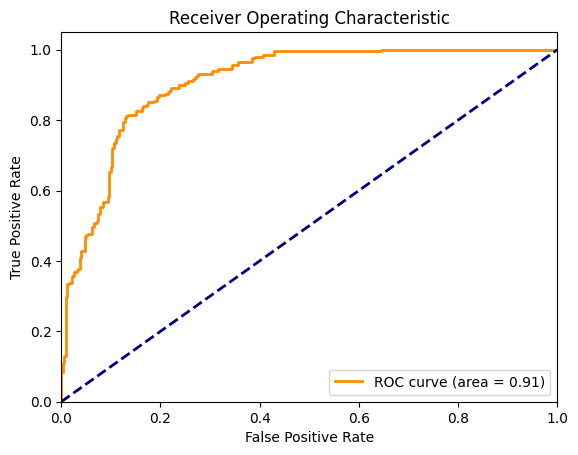

In [10]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(y_true, y_pred, target_names=['non-bleeding', 'bleeding'])
print('Classification Report')
print(cr)

# Sensitivity, Specificity, TPR, FPR for each class
tn, fp, fn, tp = cm.ravel()

# Class 0: Non-Bleeding
sensitivity_0 = tn / (tn + fp)
specificity_0 = tp / (tp + fn)
tpr_0 = sensitivity_0
fpr_0 = fn / (fn + tp)

# Class 1: Bleeding
sensitivity_1 = tp / (tp + fn)
specificity_1 = tn / (tn + fp)
tpr_1 = sensitivity_1
fpr_1 = fp / (fp + tn)

print(f"\nClass 0 - Non-Bleeding:")
print(f"Sensitivity: {sensitivity_0:.4f}")
print(f"Specificity: {specificity_0:.4f}")
print(f"True Positive Rate: {tpr_0:.4f}")
print(f"False Positive Rate: {fpr_0:.4f}")

print(f"\nClass 1 - Bleeding:")
print(f"Sensitivity: {sensitivity_1:.4f}")
print(f"Specificity: {specificity_1:.4f}")
print(f"True Positive Rate: {tpr_1:.4f}")
print(f"False Positive Rate: {fpr_1:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

# Store the ROC curve values for further use or plotting
roc_curve_values = {
    'fpr': fpr,
    'tpr': tpr,
    'thresholds': thresholds,
    'roc_auc': roc_auc
}

print(f"\nROC Curve Values:")
print(f"FPR: {roc_curve_values['fpr']}")
print(f"TPR: {roc_curve_values['tpr']}")
print(f"Thresholds: {roc_curve_values['thresholds']}")
print(f"ROC AUC: {roc_curve_values['roc_auc']:.2f}")

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()